# SECURE & PRIVATE AI CHALLENGE SCHOLARSHIP
# FINAL PROJECT
# 1. Purpose
For this project, I decided to pick the CIFAR-10 database ([Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009](http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)). I understand this work may lack depth across several evaluation components, including innovation or relevance. However, it is my goal here to encapsulate several of the concepts I learnt over the 3-month Secure & Private AI Challenge Scholarship. I had never studied Deep Learning (DL) in a concise and focused way before. Thus, this is my first proper work from the ground-up in DL.

For my own personal challenge, I will be constructing a Convolutional Neural Network, instead of using transfer learning and using a pre-trained model. Due to technical limitations and time constraints, this CNN will have considerably less layer depth than the ones considered State of the Art, as of August 2019.

Alongside the Deep Learning part of the work, I will incorporate the Privacy part of the challenge by encrypting the model and the test data. The goal here is to simulate a real-life situation in which I develop a model with data I have access to, and then I wish my model parameters to remain unknown to third parties. However, third parties that may want to use their own data in my trained model will also be concerned about their data's privacy as well. A way to make it feasible for that data to be fed into the trained model without compromising each party's private data is by combining Federated Learning and Secure Multi-Party Computation (SMPC). I will go into more detail on Section 3.

# 2. Technical Prerequisites

## 2.1 Installing and Importing packages

The focus of the Challenge was on Deep Learning and innovative techniques to render its work more secure and privacy-efficient. Such concepts included Differencial Privacy and Federated Learning. Thus, in order to successfully implement some ideas on these topics, one has to install and import PySyft, a tool which extends the capabilities of DL frameworks such as PyTorch or Tensorflow.

In [0]:
!pip install syft

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import syft as sy

import numpy as np
import matplotlib.pyplot as plt

## 2.2 Checking for CUDA
This work is being performed while using Google Colab. Therefore, whenever possible during training, I will use GPU capabilities made available by this platform.

In [29]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("CUDA is available. Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")

CUDA is available. Training on GPU...


# 3. Federated Learning

## 3.1 Hook and Workers Creation

In [0]:
# hooking torch to syft
hook = sy.TorchHook(torch)

# creating virtual workers. Names were abitrarily chosen.
anna = sy.VirtualWorker(hook, id = "anna")
zack = sy.VirtualWorker(hook, id = "zack")
client = sy.VirtualWorker(hook, id = "client")
crypto_provider = sy.VirtualWorker(hook, id = "crypto_provider")

# informing each worker about the other workers' existence
anna.add_workers([zack, client, crypto_provider])
zack.add_workers([anna, client, crypto_provider])
client.add_workers([anna, zack, crypto_provider])
crypto_provider.add_workers([anna, zack, client])

# 4. Dataset

The CIFAR-10 dataset contains 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. This is one of the datasets available in Torchvision.

In order to enlarge the dataset size, I will adopt Data Augmentation techniques, including random rotation, crop and flipping. These techniques will be performed on the training dataset.

## 4.1 Data Upload
Initially, I set the number of subprocesses to 2. However, I was facing a PicklingError during the creation of the Private Testloader and the workaround I found was to remove multiprocessing. Thus, I ended up defining num_workers = 0.

In [0]:
# dataset classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# number of subprocesses during data loading
num_workers = 0

# defining no. of samples per batch
batch_size = 128

# validation set percentage to be separated from training set
validation_size = 0.2

# defining Transformations to be used
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomCrop(32, padding = 4),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5,],
                                                            [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

# selecting train and test datasets
train_data = datasets.CIFAR10("data", train = True, download = True, transform = train_transforms)

test_data = datasets.CIFAR10("data", train = False, download = True, transform = test_transforms)

# getting indices for train and validation sets split
train_size = len(train_data)
indices = list(range(train_size))
np.random.shuffle(indices)

split = int(np.floor(validation_size * train_size))
train_idx, validation_idx = indices[split:], indices[:split]

# defining train and validation samplers
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

# creating data loaders for each subset
trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler, num_workers = num_workers)
validloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = validation_sampler, num_workers = num_workers)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)


Now, I will encrypt the test dataset (which in a real life situation I may not have access to), to ensure a higher degree of privacy.

In [0]:
# converting test data into integers and privately sharing the dataset across the network
private_testloader = []

for images, labels in testloader:
    private_testloader.append((images.cpu().fix_precision().share(anna, zack, crypto_provider = crypto_provider),
                               labels.cpu().fix_precision().share(anna, zack, crypto_provider = crypto_provider)))

## 4.2 Data Visualization
To ensure that data was uploaded correctly, below we will visualize first a batch of 20 training images, and then 20 test images.

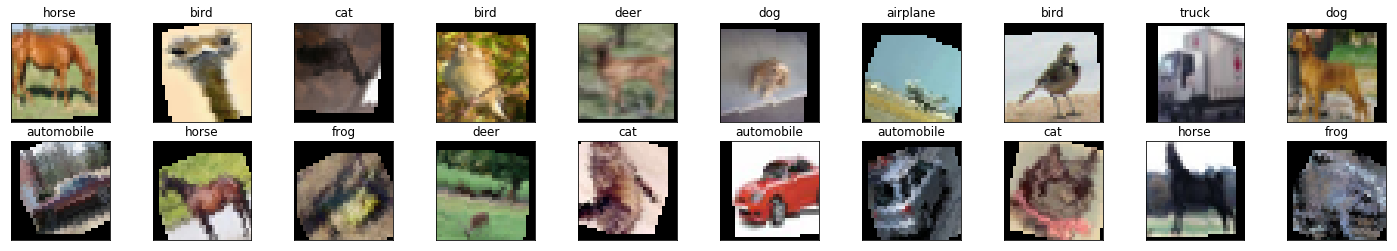

In [22]:
%matplotlib inline

# obtaining a batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# converting images for display
images = images.numpy()

fig = plt.figure(figsize = (25, 4))

# displaying 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
    
    # unnormalizing image
    images[idx] = images[idx] / 2 + 0.5
    
    # converting from tensor image
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    
    ax.set_title(classes[labels[idx]])

# 5. CNN Architecture
As we are using a dataset with coloured pictures, with size 32*32, the ideal architecture to work with is the Convolutional Neural Network (CNN).

Below, I built an architecture with 2 sequences of Convolutional and Pooling layers (each containing 2 convolutional layers and 1 pooling layer). It is then followed by 3 fully-connected layers, typical from MLP architectures.

To avoid potencial overfitting, I am considering a 20% dropout rate after each Conv+Pool sequence and each fully-connected layer. Every activation layer is a ReLU function, except the last one for the output - for which I chose a LogSoftmax function.

In [0]:
class ClassifierCNN(nn.Module):
    def __init__(self):
        super(ClassifierCNN, self).__init__()

        # convolutional layers
        self.conv1 = nn.Conv2d(3, 8, 3, padding = 1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding = 1)
        self.conv3 = nn.Conv2d(16, 16, 3, padding = 1)
        self.conv4 = nn.Conv2d(16, 32, 3, padding = 1)
        
        # pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        
        # hidden layers
        self.hidden1 = nn.Linear(32*8*8, 512)
        self.hidden2 = nn.Linear(512, 128)
        
        # output layer
        self.output = nn.Linear(128, 10)
        
        # activation layers
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim = 1)
        
        # dropout
        self.dropout = nn.Dropout(p = 0.2)
        
    def forward(self, x):
        # adding sequence of convolutional and pooling layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout(x)
        
        # flatten image
        x = x.view(-1, 32*8*8)
        
        # hidden layers
        x = self.relu(self.hidden1(x))
        x = self.dropout(x)
        
        x = self.relu(self.hidden2(x))
        x = self.dropout(x)
        
        # output
        x = self.output(x)
        x = self.logsoftmax(x)
        
        return x

In [33]:
# creating model
model = ClassifierCNN()
print(model)

ClassifierCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden1): Linear(in_features=2048, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.2)
)


https://github.com/LiyuanLucasLiu/RAdam

https://arxiv.org/abs/1908.03265v1

In [0]:
# defining loss function and optimizer
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

# 6. Training and Validating the Model

In [26]:
# setting number of training epochs
n_epochs = 120

# for tracking minimum validation loss value
valid_loss_min = np.Inf

# moving to GPU, if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(n_epochs):
    
    train_loss = 0
    valid_loss = 0
    
    # training phase
    model.train()
    
    for images, labels in trainloader:
        # moving to GPU, if CUDA is available
        images, labels = images.to(device), labels.to(device)
            
        # clearing previous gradients, if exist
        optimizer.zero_grad()
        
        # forward pass, for output prediction
        pred = model(images)
        
        # calculating loss
        loss = criterion(pred, labels)
        
        # backward pass
        loss.backward()
        
        # performing weights update
        optimizer.step()
        
        # updating training loss
        train_loss += loss.item() * images.size(0)
        
    # validation phase
    model.eval()
    
    for images, labels in validloader:
        # moving to GPU, if CUDA is available
        images, labels = images.to(device), labels.to(device)
            
        # output prediction
        pred = model(images)
        
        # calculating loss
        loss = criterion(pred, labels)
        
        # updating validation loss
        valid_loss += loss.item() * images.size(0)
    
    # calculating and printing average training / validation losses
    train_loss = train_loss / len(trainloader.dataset)
    valid_loss = valid_loss / len(validloader.dataset)
    
    print("Epoch: {} \t Training loss: {:.5f} \t Validation loss: {:.5f}".format(epoch+1, train_loss, valid_loss))
    
    # if validation loss reaches new minimum, model parameters are saved
    if valid_loss < valid_loss_min:
        print("Validation loss decreased: {:.5f} --> {:.5f}. Saving the model...".format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), "showcase_project.pt")
        valid_loss_min = valid_loss

Epoch: 1 	 Training loss: 1.54510 	 Validation loss: 0.34043
Validation loss decreased: inf --> 0.34043. Saving the model...
Epoch: 2 	 Training loss: 1.33108 	 Validation loss: 0.30446
Validation loss decreased: 0.34043 --> 0.30446. Saving the model...
Epoch: 3 	 Training loss: 1.23050 	 Validation loss: 0.29128
Validation loss decreased: 0.30446 --> 0.29128. Saving the model...
Epoch: 4 	 Training loss: 1.17159 	 Validation loss: 0.27262
Validation loss decreased: 0.29128 --> 0.27262. Saving the model...
Epoch: 5 	 Training loss: 1.13121 	 Validation loss: 0.26225
Validation loss decreased: 0.27262 --> 0.26225. Saving the model...
Epoch: 6 	 Training loss: 1.09406 	 Validation loss: 0.25635
Validation loss decreased: 0.26225 --> 0.25635. Saving the model...
Epoch: 7 	 Training loss: 1.06730 	 Validation loss: 0.24635
Validation loss decreased: 0.25635 --> 0.24635. Saving the model...
Epoch: 8 	 Training loss: 1.04632 	 Validation loss: 0.24799
Epoch: 9 	 Training loss: 1.02241 	 Vali

# 7. Testing the Model

Before testing the model, we must upload the parameters with which the model obtained the lowest validation loss in the previous section.

In [0]:
model.load_state_dict(torch.load("showcase_project.pt"))

Now, we have all we need to properly test the model. To do so, we will use the test dataset, which contains images that the model hasn't previously seen.

There are 2 approaches to test our model:
- using the entire test dataset, to obtain a global test loss
- visualizing sample test results, using a small batch

Here, we will use both approaches.

## 7.1 Testing with no Encryption
Let's first create a benchmark, so that we can compare how an encrypted Deep Learning model fares against the traditional method of training and testing a DL model.

That benchmark will be testing without encrypting neither the model, nor the data.

In [37]:
# setting test loss
test_loss = 0

# preparing accuracy calculation per class
class_correct = list(0. for i in range(10)) # range value corresponds to the no. of classes
class_total = list(0. for i in range(10))

# setting model to evaluation mode
model.eval()

with torch.no_grad():
    for images, labels in testloader:
    # moving to GPU, if CUDA is available
        if train_on_gpu:
            images, labels = images.to(device), labels.to(device)

        # output prediction
        pred = model(images)

        # calculating loss
        loss = criterion(pred, labels)

        # updating test loss
        test_loss += loss.item() * images.size(0)

        # converting output to predicted class
        _, pred = torch.max(pred, 1)

        # comparing prediction to true label
        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

        # calculating test accuracy for each class
        for i in range(len(labels.data) - 1):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        
# average test loss
test_loss = test_loss / len(testloader.dataset)
print("Test loss: {:.5f}\n".format(test_loss))

# printing accuracy per class and global accuracy
for i in range(10):
    if class_total[i] > 0:
        print("Test Accuracy of {}: {:.3f} ({}/{})".format(classes[i],
                                                     class_correct[i] / class_total[i] * 100,
                                                     np.sum(class_correct[i]),
                                                     np.sum(class_total[i])))
    else:
        print("Test Accuracy of {}: N/A (no examples available)".format(classes[i]))
        
print("\nTest Accuracy (Overall): {:.3f} ({}/{})".format(np.sum(class_correct) / np.sum(class_total) * 100,
                                                         np.sum(class_correct),
                                                         np.sum(class_total)))

Test loss: 0.69618

Test Accuracy of airplane: 79.435 (788.0/992.0)
Test Accuracy of automobile: 91.010 (901.0/990.0)
Test Accuracy of bird: 70.741 (706.0/998.0)
Test Accuracy of cat: 41.851 (416.0/994.0)
Test Accuracy of deer: 71.227 (708.0/994.0)
Test Accuracy of dog: 74.220 (737.0/993.0)
Test Accuracy of frog: 81.117 (799.0/985.0)
Test Accuracy of horse: 78.969 (781.0/989.0)
Test Accuracy of ship: 86.162 (853.0/990.0)
Test Accuracy of truck: 80.321 (800.0/996.0)

Test Accuracy (Overall): 75.486 (7489.0/9921.0)


## 7.2 Encrypting the Model
Before finding the test loss, we have to ensure the 3rd party has no access to the model we just trained. Therefore, we have to encrypt it and share it across the different workers present in the network (created in Section 3).

In [42]:
# encrypting loaded model
model = model.cpu()
model.fix_precision().share(anna, zack, crypto_provider=crypto_provider)

RuntimeError: ignored

## 7.3 Calculating Test Loss with Encryption

In [28]:
# setting test loss
test_loss = 0

# preparing accuracy calculation per class
class_correct = list(0. for i in range(10)) # range value corresponds to the no. of classes
class_total = list(0. for i in range(10))

# setting model to evaluation mode
model.eval()

with torch.no_grad():
    for images, labels in private_testloader:
    # moving to GPU, if CUDA is available
        if train_on_gpu:
            images, labels = images.to(device), labels.to(device)

        # output prediction
        pred = model(images)

        # calculating loss
        loss = criterion(pred, labels)

        # updating test loss
        test_loss += loss.item() * images.size(0)

        # converting output to predicted class
        _, pred = torch.max(pred, 1)

        # comparing prediction to true label
        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

        # calculating test accuracy for each class
        for i in range(len(labels.data) - 1):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        
# average test loss
test_loss = test_loss / len(private_testloader.dataset)
print("Test loss: {:.5f}\n".format(test_loss))

# printing accuracy per class and global accuracy
for i in range(10):
    if class_total[i] > 0:
        print("Test Accuracy of {}: {:.3f} ({}/{})".format(classes[i],
                                                     class_correct[i] / class_total[i] * 100,
                                                     np.sum(class_correct[i]),
                                                     np.sum(class_total[i])))
    else:
        print("Test Accuracy of {}: N/A (no examples available)".format(classes[i]))
        
print("\nTest Accuracy (Overall): {:.3f} ({}/{})".format(np.sum(class_correct) / np.sum(class_total) * 100,
                                                         np.sum(class_correct),
                                                         np.sum(class_total)))

KeyError: ignored

## 7.4 Sample Test Visualization

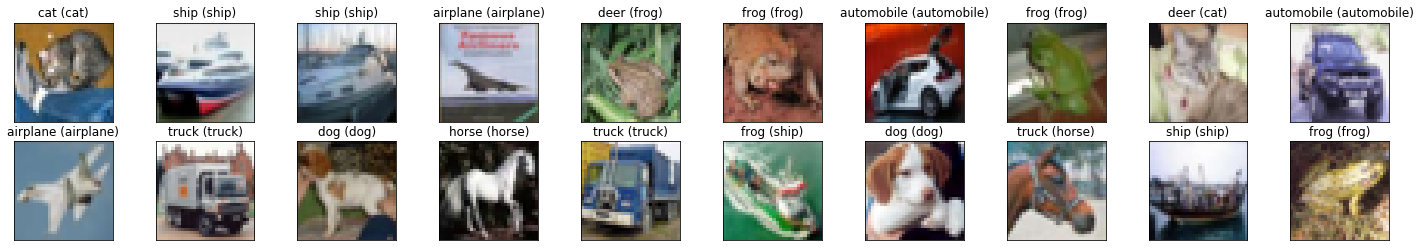

In [41]:
# obtaining a batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

images.numpy()

# setting model to evaluation mode
model.eval()

# moving to GPU, if CUDA is available
if train_on_gpu:
    images, labels = images.cuda(), labels.cuda()
    
# output prediction
pred = model(images)

# converting output to predicted class
_, pred_tensor = torch.max(pred, 1)
pred = np.squeeze(pred_tensor.numpy()) if not train_on_gpu else np.squeeze(pred_tensor.cpu().numpy())

# plotting images, prediction and true labels
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
    
    # unnormalizing image
    images[idx] = images[idx] / 2 + 0.5

    # converting from tensor image
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    
    ax.set_title("{} ({})".format(classes[pred[idx]], classes[labels[idx]],
                                  color = ("green" if pred[idx] == labels[idx].item() else "red")))

# 8. Conclusions
I originally had intended to present a final work with:
- a Deep Learning model trained and tested under the traditional standards, without any encryption;
- a Deep Learning model trained under the traditional standards, without any encryption, but tested with encrypted parameters and dataset;

Although I successfully achieved the first goal with a meritous 75% accuracy on the CIFAR-10 dataset, given the simplicity of my CNN architecture, that was not enough. Despite several debuggings over the past couple of days, I have solved all pending issues and I will have to present the work as-is, due to the August 20th deadline established by the course officials.

However, it is my intention to solve the remaining issues by August 30th, which is the Challenge's Phase 1 deadline.